## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.io import read_file
from tensorflow.image import decode_image, resize
from tensorflow import expand_dims
from sklearn.metrics import confusion_matrix, classification_report

## Data Loading

In [2]:
fire = pd.DataFrame(columns=['image', 'width', 'height', 'label'])

for dirpath, dirnames, filenames in os.walk('dataset/fire_dataset/train/fire'):
    for filename in filenames:
        filepath = os.path.join(dirpath, filename)
        img = image.load_img(filepath)
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array / 255
        fire = fire.append({'image': filepath, 'width': img.size[0], 'height': img.size[1], 'label': 'fire'}, ignore_index=True)

for dirpath, dirnames, filenames in os.walk('dataset/fire_dataset/train/non_fire'):
    for filename in filenames:
        filepath = os.path.join(dirpath, filename)
        img = image.load_img(filepath)
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array / 255
        fire = fire.append({'image': filepath, 'width': img.size[0], 'height': img.size[1], 'label': 'non_fire'}, ignore_index=True)

for dirpath, dirnames, filenames in os.walk('dataset/fire_dataset/test/fire'):
    for filename in filenames:
        filepath = os.path.join(dirpath, filename)
        img = image.load_img(filepath)
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array / 255
        fire = fire.append({'image': filepath, 'width': img.size[0], 'height': img.size[1], 'label': 'fire'}, ignore_index=True)

for dirpath, dirnames, filenames in os.walk('dataset/fire_dataset/test/non_fire'):
    for filename in filenames:
        filepath = os.path.join(dirpath, filename)
        img = image.load_img(filepath)
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array / 255
        fire = fire.append({'image': filepath, 'width': img.size[0], 'height': img.size[1], 'label': 'non_fire'}, ignore_index=True)

In [3]:
fire.head()

,image,width,height,label
0,dataset/fire_dataset/train/fire\fire.152.png,1024,683,fire
1,dataset/fire_dataset/train/fire\fire.153.png,958,641,fire
2,dataset/fire_dataset/train/fire\fire.154.png,500,333,fire
3,dataset/fire_dataset/train/fire\fire.155.png,940,470,fire
4,dataset/fire_dataset/train/fire\fire.156.png,880,495,fire


### Data Characteristics

In [4]:
fire.shape

(1462, 4)

In [5]:
fire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   1462 non-null   object
 1   width   1462 non-null   object
 2   height  1462 non-null   object
 3   label   1462 non-null   object
dtypes: object(4)
memory usage: 45.8+ KB


## Data Cleaning

### Convert Data Types

In [6]:
fire['width'] = fire['width'].astype(int)
fire['height'] = fire['height'].astype(int)

## Exploratory Data Analysis (EDA)

### Label

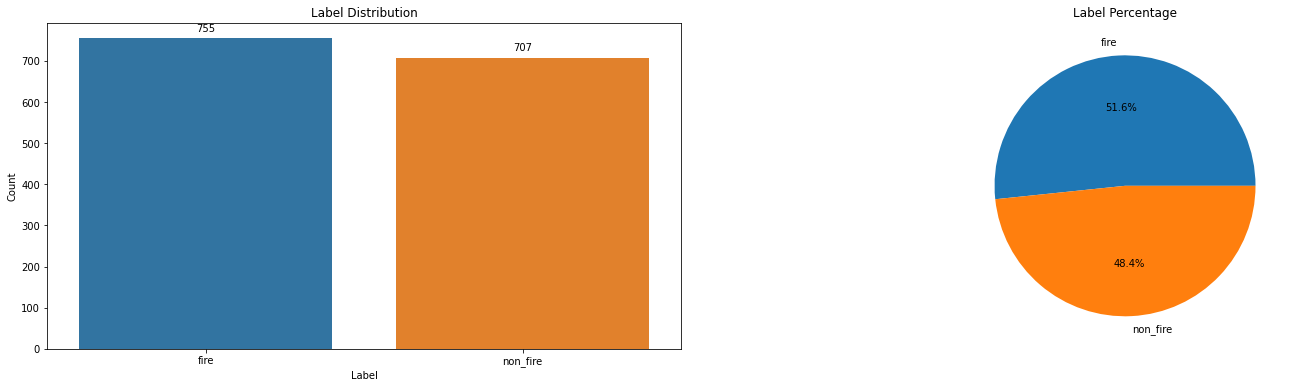

In [7]:
plt.figure(figsize=(25, 6))
plt.subplot(1, 2, 1)
fig = sns.countplot(x='label', data=fire)
for p in fig.patches:
    fig.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.subplot(1, 2, 2)
plt.pie(fire.label.value_counts(), labels=fire.label.value_counts().index, autopct='%1.1f%%')
plt.title('Label Percentage')
plt.show()

### Width and Height

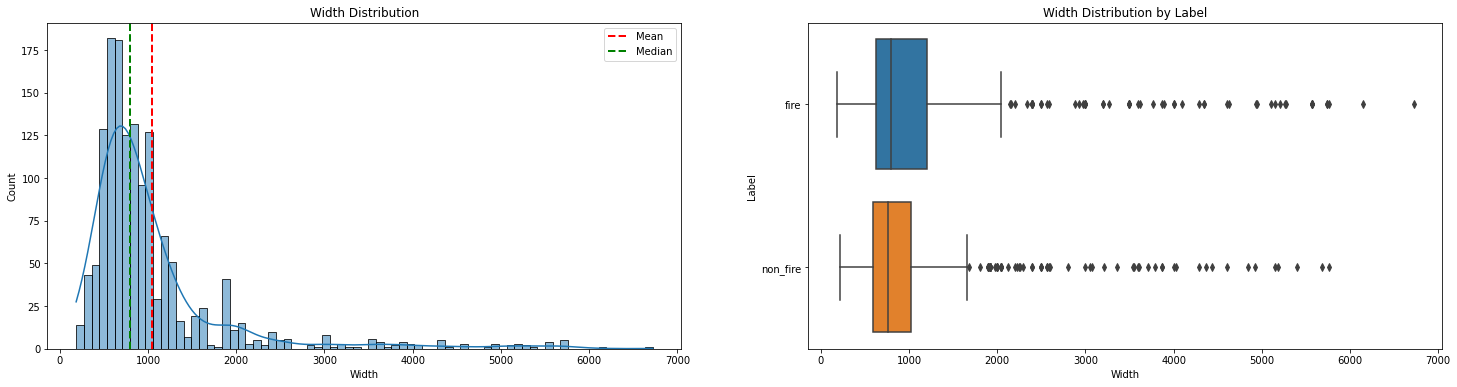

Mean: 1046
Median: 800


In [8]:
plt.figure(figsize=(25, 6))
plt.subplot(1, 2, 1)
sns.histplot(x='width', data=fire, kde=True)
plt.axvline(fire.width.mean(), color='red', linestyle='dashed', linewidth=2, label='Mean')
plt.axvline(fire.width.median(), color='green', linestyle='dashed', linewidth=2, label='Median')
plt.title('Width Distribution')
plt.xlabel('Width')
plt.ylabel('Count')
plt.legend()
plt.subplot(1, 2, 2)
sns.boxplot(x='width', y='label', data=fire)
plt.title('Width Distribution by Label')
plt.xlabel('Width')
plt.ylabel('Label')
plt.show()
print(f'Mean: {fire.width.mean():.0f}')
print(f'Median: {fire.width.median():.0f}')

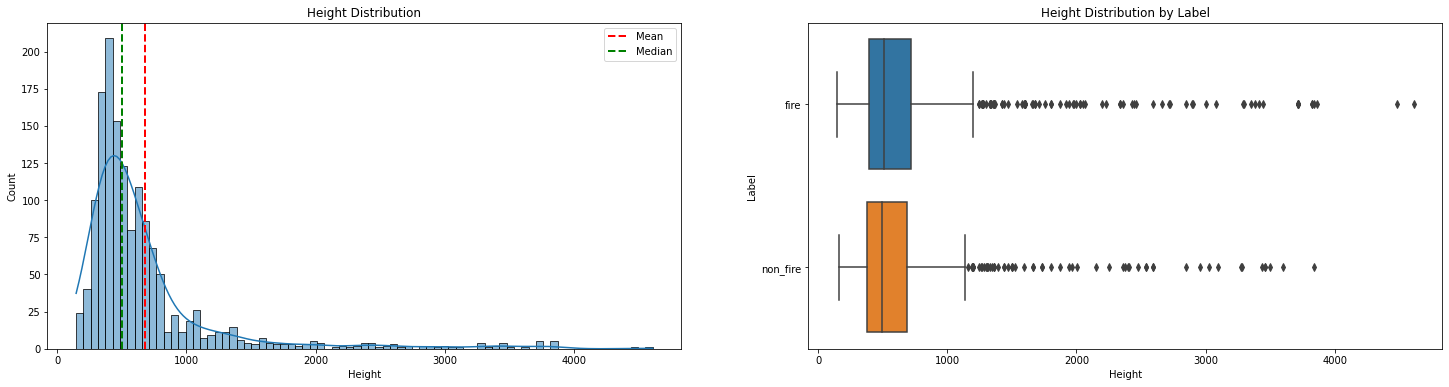

Mean: 678
Median: 500


In [9]:
plt.figure(figsize=(25, 6))
plt.subplot(1, 2, 1)
sns.histplot(x='height', data=fire, kde=True)
plt.axvline(fire.height.mean(), color='red', linestyle='dashed', linewidth=2, label='Mean')
plt.axvline(fire.height.median(), color='green', linestyle='dashed', linewidth=2, label='Median')
plt.title('Height Distribution')
plt.xlabel('Height')
plt.ylabel('Count')
plt.legend()
plt.subplot(1, 2, 2)
sns.boxplot(x='height', y='label', data=fire)
plt.title('Height Distribution by Label')
plt.xlabel('Height')
plt.ylabel('Label')
plt.show()
print(f'Mean: {fire.height.mean():.0f}')
print(f'Median: {fire.height.median():.0f}')

### Sample Images

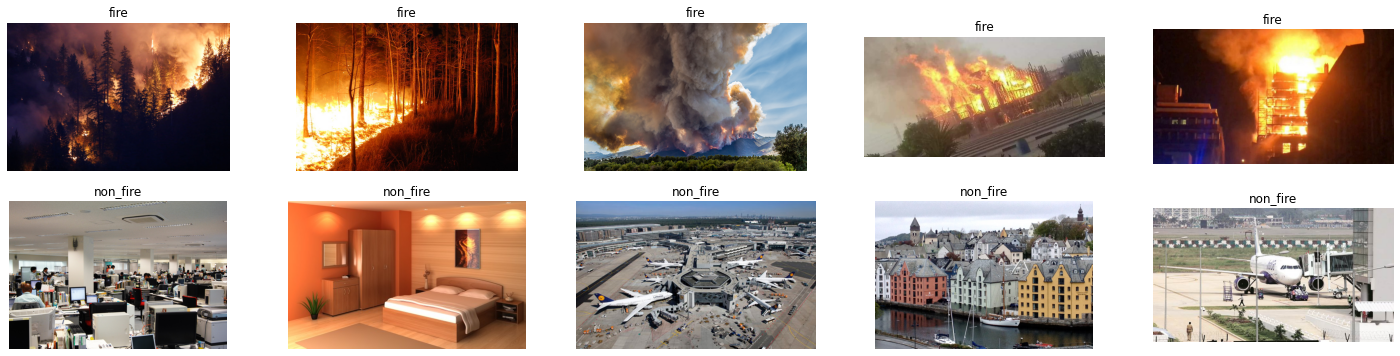

In [10]:
plt.figure(figsize=(25, 6))
counter = 1
for i in ['fire', 'non_fire']:
    for j in range(5):
        plt.subplot(2, 5, counter)
        img = image.load_img(fire[fire.label == i].iloc[j]['image'])
        plt.imshow(img)
        plt.title(i)
        plt.axis('off')
        counter += 1
plt.show()

## Data Preprocessing

In [11]:
train_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, vertical_flip=True, rotation_range=90, width_shift_range=0.4, height_shift_range=0.4, shear_range=0.4, zoom_range=0.4)
valid_gen = ImageDataGenerator(rescale=1./255)

train_dir = 'dataset/fire_dataset/train/'
test_dir = 'dataset/fire_dataset/test/'

train_data = train_gen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=23, class_mode='binary')
valid_data = valid_gen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=23, class_mode='binary')

Found 1170 images belonging to 2 classes.
Found 292 images belonging to 2 classes.


## Model Definition

In [12]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dense (Dense)               (None, 16)                2

## Model Training

In [15]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_data, epochs=25, validation_data=valid_data)

Epoch 1/25
51/51 [==============================] - 30s 576ms/step - loss: 0.4178 - accuracy: 0.8521 - val_loss: 0.5310 - val_accuracy: 0.7432
Epoch 2/25
51/51 [==============================] - 29s 567ms/step - loss: 0.3999 - accuracy: 0.8573 - val_loss: 0.5553 - val_accuracy: 0.7158
Epoch 3/25
51/51 [==============================] - 29s 575ms/step - loss: 0.4138 - accuracy: 0.8496 - val_loss: 0.5365 - val_accuracy: 0.7226
Epoch 4/25
51/51 [==============================] - 29s 567ms/step - loss: 0.3993 - accuracy: 0.8615 - val_loss: 0.4963 - val_accuracy: 0.7534
Epoch 5/25
51/51 [==============================] - 29s 573ms/step - loss: 0.3933 - accuracy: 0.8581 - val_loss: 0.4548 - val_accuracy: 0.8219
Epoch 6/25
51/51 [==============================] - 29s 572ms/step - loss: 0.3996 - accuracy: 0.8530 - val_loss: 0.4976 - val_accuracy: 0.7568
Epoch 7/25
51/51 [==============================] - 29s 567ms/step - loss: 0.3917 - accuracy: 0.8607 - val_loss: 0.5370 - val_accuracy: 0.7329

## Model Evaluation

In [16]:
metrics = pd.DataFrame(history.history)
metrics.tail()

,loss,accuracy,val_loss,val_accuracy
20,0.341071,0.876923,0.473053,0.791096
21,0.336620,0.869231,0.507553,0.753425
22,0.339147,0.871795,0.449330,0.791096
23,0.339556,0.875214,0.446970,0.791096
24,0.347066,0.867521,0.392718,0.832192


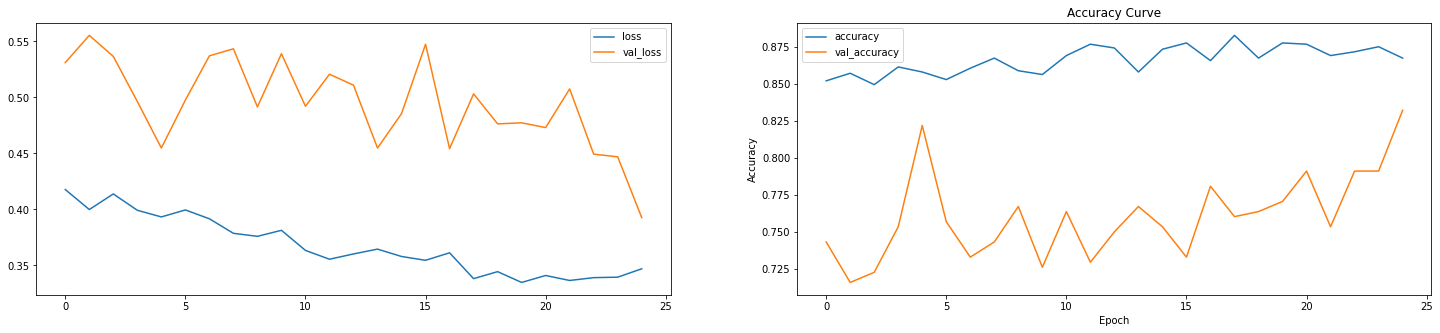

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(25, 5))
metrics[['loss', 'val_loss']].plot(ax=ax[0])
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
metrics[['accuracy', 'val_accuracy']].plot(ax=ax[1])
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

<AxesSubplot:>

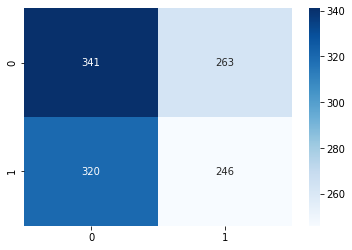

In [18]:
# Confusion Matrix
y_pred = model.predict(train_data)
y_pred = (y_pred > 0.5).astype(int)
y_true = train_data.classes

conf = confusion_matrix(y_true, y_pred)
sns.heatmap(conf, annot=True, fmt='d', cmap='Blues')

## Model Improvement

In [65]:
# Create the model
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(Dropout(0.5))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adamax', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_data, epochs=25, validation_data=valid_data)

Epoch 1/25
51/51 [==============================] - 33s 610ms/step - loss: 0.6309 - accuracy: 0.7419 - val_loss: 0.6107 - val_accuracy: 0.7089
Epoch 2/25
51/51 [==============================] - 30s 595ms/step - loss: 0.4387 - accuracy: 0.8239 - val_loss: 0.5566 - val_accuracy: 0.7363
Epoch 3/25
51/51 [==============================] - 30s 592ms/step - loss: 0.3926 - accuracy: 0.8222 - val_loss: 0.5370 - val_accuracy: 0.7534
Epoch 4/25
51/51 [==============================] - 29s 566ms/step - loss: 0.4000 - accuracy: 0.8402 - val_loss: 0.5474 - val_accuracy: 0.7534
Epoch 5/25
51/51 [==============================] - 30s 572ms/step - loss: 0.3773 - accuracy: 0.8462 - val_loss: 0.5318 - val_accuracy: 0.7705
Epoch 6/25
51/51 [==============================] - 30s 582ms/step - loss: 0.4012 - accuracy: 0.8239 - val_loss: 0.5337 - val_accuracy: 0.7774
Epoch 7/25
51/51 [==============================] - 30s 575ms/step - loss: 0.3871 - accuracy: 0.8453 - val_loss: 0.5233 - val_accuracy: 0.7842

In [66]:
metrics = pd.DataFrame(history.history)
metrics.tail()

,loss,accuracy,val_loss,val_accuracy
20,0.326849,0.870085,0.474513,0.808219
21,0.324531,0.864957,0.434090,0.818493
22,0.325167,0.873504,0.447629,0.828767
23,0.302635,0.879487,0.463734,0.818493
24,0.315189,0.870940,0.455868,0.801370


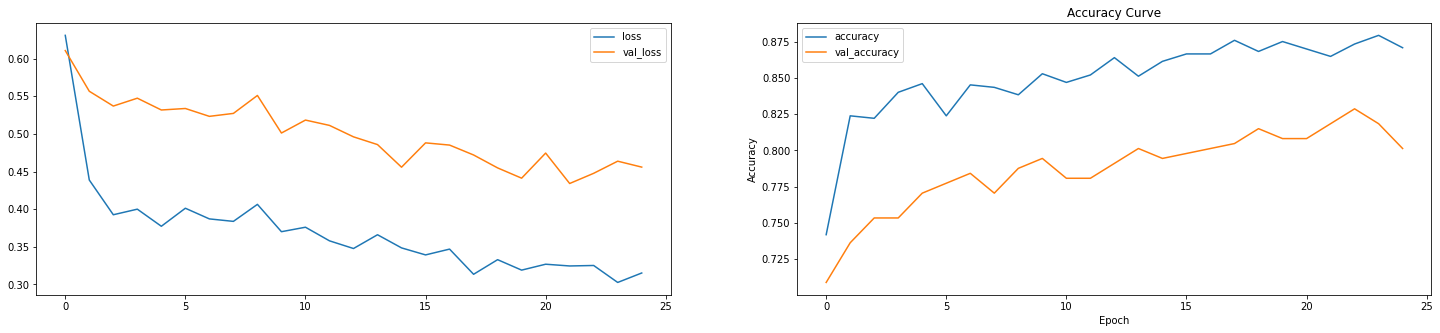

In [67]:
fig, ax = plt.subplots(1, 2, figsize=(25, 5))
metrics[['loss', 'val_loss']].plot(ax=ax[0])
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
metrics[['accuracy', 'val_accuracy']].plot(ax=ax[1])
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

## Model Testing

In [73]:
def load_img(filename, img_shape=224):
  img = read_file(filename)
  img = decode_image(img, channels=3)
  img = resize(img, size=[img_shape, img_shape])
  img = img/255.
  return img

In [74]:
img1 = load_img('img1.jpg')
img2 = load_img('img2.jpg')
img3 = load_img('img3.jpg')
img4 = load_img('img4.jpg')
img5 = load_img('img5.jpg')

In [75]:
train_data.class_indices

{'fire': 0, 'non_fire': 1}

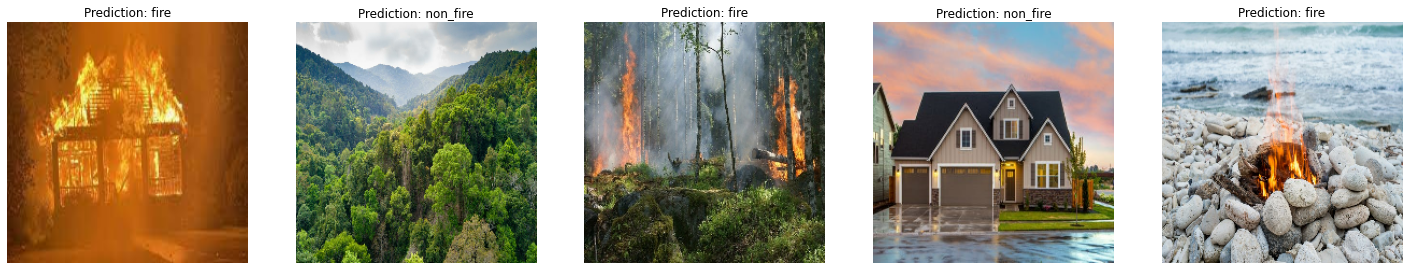

In [76]:
plt.figure(figsize=(25, 6))
counter = 1
for i in [img1, img2, img3, img4, img5]:
    plt.subplot(1, 5, counter)
    res = int(tf.round(model.predict(x=expand_dims(i, axis=0))))
    plt.imshow(i)
    plt.title(f"Prediction: {'fire' if res == 0 else 'non_fire'}")
    plt.axis('off')
    counter += 1
plt.show()  

In [77]:
from PIL import Image
import requests
from io import BytesIO

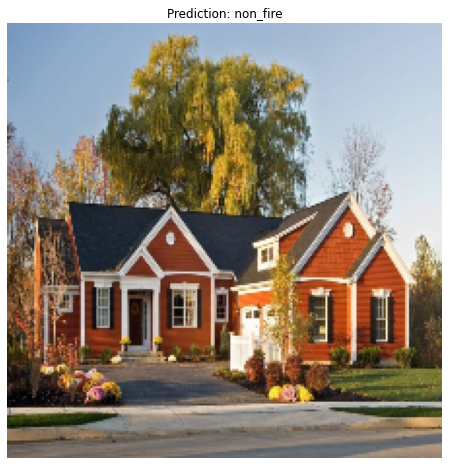

In [105]:
url = "https://cdn.homedit.com/wp-content/uploads/2017/06/Ranch-exterior-in-deep-orange-1024x680.jpg"
response = requests.get(url)
img = Image.open(BytesIO(response.content))
img = np.array(img)
img = resize(img, size=[224, 224])
img = img/255.
plt.figure(figsize=(8, 8))
plt.imshow(img)
res = int(tf.round(model.predict(x=expand_dims(img, axis=0))))
plt.title(f"Prediction: {'fire' if res == 0 else 'non_fire'}")
plt.axis('off')
plt.show()